### Web scrapping. Load table from website. NOTE: Clean data is loaded later in case website is no longer available.

### Team Name

In [1]:
team_name = 'Rams'

In [2]:
#https://www.coursera.org/learn/python-plotting/discussions/weeks/4/threads/yMT7zw2KEeeqzRJFs29uDA

import pandas as pd
from IPython.display import display, HTML


def install_module(module):
    ! conda install "$module" -y
    js_cmd = ['IPython.notebook.kernel.restart();',
              'IPython.notebook.select(1);',
              'IPython.notebook.execute_cell();'
              ]
    js = "<script>{0}</script>".format(' '.join(js_cmd))
    display(HTML(js))

#url = 'https://simple.wikipedia.org/wiki/List_of_U.S._states'
url = 'https://en.wikipedia.org/wiki/List_of_Los_Angeles_Rams_seasons'
try:
    df_list = pd.read_html(url)
except Exception as e:
    print(e)
    # #install necessary modules for read_html
    module = str(e).split()[0]
    install_module(module)
print('Number of Data Frames {}'.format(len(df_list)))
df_list[0].columns = df_list[0].iloc[0]
df = df_list[0].iloc[1:]
df.head()

Number of Data Frames 10


,This article is part of series of
1,Rams NFL franchise history
2,Cleveland Rams (1936–45)
3,Los Angeles Rams (1946–94)
4,St. Louis Rams (1995–2015)
5,Los Angeles Rams (2016–present)


### Multiple tables found. Capture them all in a list of dataframes.

In [3]:
# https://stackoverflow.com/questions/42225204/use-pandas-to-get-multiple-tables-from-webpage

import urllib
from bs4 import BeautifulSoup
url = 'https://en.wikipedia.org/wiki/List_of_Los_Angeles_Rams_seasons'
html_table = urllib.request.urlopen(url).read()

# fix HTML
soup = BeautifulSoup(html_table, "html.parser")
# warn! id ratings-table is your page specific
for table in soup.findChildren(attrs={'id': 'ratings-table'}): 
    for c in table.children:
        if c.name in ['tbody', 'thead']:
            c.unwrap()

list_df = pd.read_html(str(soup), flavor="bs4")
len(list_df[0])

8

### This is the table we are interested it.

In [4]:
#list_df[2][15:].head()
#list_df[0].head()
#list_df[0].tail(10)
df_rams = list_df[2]
df_rams.head()

,0,1,2,3,4,5,6,7,8,9,10
0,Season,Team,League,Conference,Division,Regular season,Postseason results,Awards,NaN,NaN,NaN
1,Finish,Wins,Losses,Ties,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Cleveland Rams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1936,1936,AFL,NaN,NaN,2nd,5,2,2,[2][3][4],NaN
4,1937,1937,NFL,NaN,West,5th,1,10,0,NaN,NaN


### Save raw data .csv

In [5]:
file_name = team_name +'_data_raw'

#csv
df_rams.to_csv( file_name +'.csv')

### Clean the data. Make the first row the header for the columns.

In [6]:
# Make the first row the header column
# NOTE: This does not get rid of the row.
df_rams.columns = df_rams.iloc[0]

# Re-index and drop the first row.
df_rams_cleaned = df_rams.reindex(df_rams.index.drop(0))

# Keep the rows we want (i.e. the years they became the team for the city.)
df_rams_cleaned = df_rams_cleaned[37:87]

# Drop the rows we do not need.
df_rams_cleaned.reset_index(drop = True,
                               inplace = True)
df_rams_cleaned = df_rams_cleaned.drop(df_rams_cleaned.index[[25,47,49]])


# Keep columns of interest.
# https://stackoverflow.com/questions/14940743/selecting-excluding-sets-of-columns-in-pandas
columns_to_keep = ['Season', 'Postseason results', 'Awards']
df_rams_cleaned = df_rams_cleaned[columns_to_keep]

# Rename the columns
df_rams_cleaned.columns = ['Season', 'Wins', 'Losses']

# Change the year to have only the first year and not a range.
# i.e. 1960 and not 1961-62
df_rams_cleaned['Season'] = df_rams_cleaned['Season'].apply(lambda x: x[:4])

# # # Check type
# # #df_rams_cleaned.dtypes

# # # NOTE:
# # # Year 2004-05, Season cancelled due to 2004–05 NHL lockout
# # #
# # # https://stackoverflow.com/questions/18434208/pandas-converting-to-numeric-creating-nans-when-necessary
df_rams_cleaned = df_rams_cleaned.apply(pd.to_numeric, errors='coerce')
#df_rams_cleaned['Wins'] = df_rams_cleaned['Wins'].apply(pd.to_numeric, errors='coerce')
# # df_rams_cleaned['Losses'] = df_rams_cleaned['Losses'].apply(pd.to_numeric, errors='coerce')



# # # Convert to date float because int64 can't use NaN (not a number)
# # # https://stackoverflow.com/questions/41550746/error-using-astype-when-nan-exists-in-a-dataframe
# # #
# # #df_rams_cleaned['Season'] = df_rams_cleaned['Season'].astype('int64')
df_rams_cleaned = df_rams_cleaned.astype('float')
# # #df_rams_cleaned = df_rams_cleaned.astype('int64')

# # # Front fill and NaN value.
# # # Front fill means use the last known value
# # # Back fill means use the next known value
df_rams_cleaned = df_rams_cleaned.ffill()

# # # Check type
# # # df_rams_cleaned.dtypes

# # # Make column of win percent
df_rams_cleaned['Win_Percent'] = df_rams_cleaned['Wins'] / (df_rams_cleaned['Wins'] + df_rams_cleaned['Losses'])

# Make column for moving average (rolling mean)
#
# NOTE: You will not see the rolling mean for the first few rows because you need
#       the minimum window size before it calculates.
# This will be deprecated in the future
# df_rams_cleaned['Rolling Mean'] = pd.rolling_mean( df_rams_cleaned['Wins'],
#                                                    
#                                                      # window to calculate
#                                                      10)
df_rams_cleaned['Rolling_Mean'] = df_rams_cleaned['Win_Percent'].rolling( window = 10, center = False).mean()

# Only save from 1980 because that is the only
# overlap from all the data.
#
# NOTE: Not including 2017 to line up with the other data.
df_rams_cleaned = df_rams_cleaned[10:]


# Reset index.
# NOTE: drop = True means do not make a new index and keep old.
#       inplace = True means update this variable and not return a copy
#                      leaving original intact.
df_rams_cleaned.reset_index(drop = True,
                              inplace = True)

# # #df_rams_cleaned.head(20)

df_rams_cleaned

,Season,Wins,Losses,Win_Percent,Rolling_Mean
0,1980.0,11.0,5.0,0.687500,0.698901
1,1981.0,6.0,10.0,0.375000,0.674863
2,1982.0,2.0,7.0,0.222222,0.650931
3,1983.0,9.0,7.0,0.562500,0.621467
4,1984.0,10.0,6.0,0.625000,0.612538
5,1985.0,11.0,5.0,0.687500,0.595574
6,1986.0,10.0,6.0,0.625000,0.581151
7,1987.0,6.0,9.0,0.400000,0.549722
8,1988.0,10.0,6.0,0.625000,0.537222
9,1989.0,11.0,5.0,0.687500,0.549722


### Save clean data to .csv

In [7]:
file_name = team_name +'_data_cleaned'

#csv
df_rams_cleaned.to_csv( file_name +'.csv')


### Load clean data from file instead of web scrapping.

In [8]:
file_name = team_name +'_data_cleaned'
df_rams_cleaned = pd.read_csv( file_name +'.csv',
                 
                                 # Use the first column as the index
                                 index_col = 0)
df_rams_cleaned.tail()

,Season,Wins,Losses,Win_Percent,Rolling_Mean
32,2012.0,7.0,8.0,0.466667,0.352917
33,2013.0,7.0,9.0,0.437500,0.321667
34,2014.0,6.0,10.0,0.375000,0.309167
35,2015.0,7.0,9.0,0.437500,0.315417
36,2016.0,4.0,12.0,0.250000,0.290417


### Plot moving average

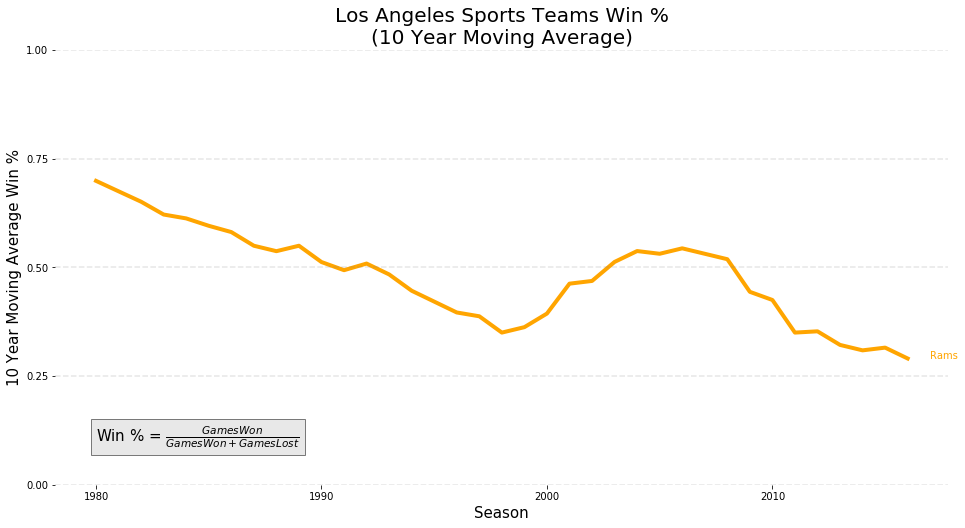

In [9]:
import matplotlib.pyplot as plt
import numpy as np

#----------------
# Variables
# (Start)
#----------------

graph_color = 'orange'

#----------------
# Variables
# (End)
#----------------

# Create new figure
fig_lakers = plt.figure(figsize = (16,8))
ax = fig_lakers.add_subplot(111)

# TODO
#
# -Set title
# -Set x label
# -Set y lable
# -Set x-axis to be the whole data but only show 10 year intervals
# -Set y-axis for 0.0 to 1.0 but have dotted lines from 0.0, 0.25, 0.75, 1.0 BUT only use the highest that contain data.
# -Set thick lines.
# -Set dotted lines at y-axis intervals 
# -Set annotations for names of team next to plot lines
# -Set annotations for win%
# Remove plot box
# Change the name of the figure to be generic for all teams and the save image.



# Title
plt.title('Los Angeles Sports Teams Win %'
           '\n(10 Year Moving Average)',
           fontsize=20 )

# Labels for x and y axes
plt.xlabel( 'Season',
             fontsize=15 )
plt.ylabel( '10 Year Moving Average Win %',
            fontsize=15 )

# Create graph
plot_lakers = plt.plot( df_rams_cleaned['Season'], 
                        df_rams_cleaned['Rolling_Mean'],
                        c=graph_color,
                        label='Lakers')

# Set limit on x-axis
#ax.set_xlim([datetime.date(2016, 1, 1), datetime.date(2016, 12, 31)])
ax.set_ylim(0.0, 0.85)

# Set line thickness and style (like dotted)
# https://matplotlib.org/examples/pylab_examples/set_and_get.html
# plt.setp(plot_lakers, 
#          linestyle='--')
plt.setp(plot_lakers, 
         linewidth=4)

# https://stackoverflow.com/questions/24943991/matplotlib-change-grid-interval-and-specify-tick-labels
#
# Set x-axis to be the whole data but only show 10 year intervals
x_major_ticks = np.arange(1980, 2020, 10)
#x_minor_ticks = np.arange(1980, 2020, 1)                                               
#
ax.set_xticks(x_major_ticks)                                                       
# ax.set_xticks(x_minor_ticks, minor=True)   
#
# Set y-axis for 0.0 to 1.0 but have dotted lines from 0.0, 0.25, 0.75, 1.0 BUT only use the highest that contain data.
y_major_ticks = np.arange(0.0, 1.1, 0.25)
#
# Slice to exclude the first and last entry.
#y_major_ticks = y_major_ticks[:-1]
ax.set_yticks(y_major_ticks)

# Draw horizontal lines
for num in y_major_ticks:
    plt.axhline(y = num,
                linestyle = '--',
                color = 'grey',
                alpha = 0.2 )

# Text for team names.
# Setting up equations in matplotlib text.
# https://matplotlib.org/users/mathtext.html
#team_name = 'Lakers'
x_pos = 2017
y_pos = df_rams_cleaned['Rolling_Mean'].iloc[-1]
team_color = graph_color
font_size = 10

# # Drop Shadow
# plt.text(x_pos + 0.0005,
#          y_pos - 0.0005,
#          team_name,
#          color = 'black',
#          fontsize = font_size)

plt.text(x_pos,
         y_pos,
         team_name,
         color = team_color,
         fontsize = font_size)


# Legend
plt.text(1980,
         0.1,
         #'Win % = Games Won\(Games Won + Games Lost)',
         #r'$\frac{5 - \frac{1}{x}}{4}$',
         r'Win % = $\frac{Games Won}{Games Won + Games Lost}$',
         fontsize = 15,
         bbox={'facecolor':'lightgrey', 'alpha':0.5, 'pad':5})


# Remove axis
#plt.axis('off')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show the graph.
plt.show()


### Save graph to .png

In [10]:
# https://stackoverflow.com/questions/9012487/matplotlib-pyplot-savefig-outputs-blank-image

# plt.show()  creates a new figure.
# Use the figure captured when created.
#plt.savefig('Los_Angeles_Sports_Teams_Win_Percentage.png')
file_name = team_name +'_win_percentage'

# For some reason, matplotlib saves the image name with upper case as the first letter
# even if it is lowercase.
fig_lakers.savefig( file_name +'.png' )